In [1]:
import re
import spacy
import pandas as pd
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score as balance_acuarcy_score
from sklearn.metrics import roc_auc_score as AUC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Descargar y cargar modelo de spaCy
tokenizer = spacy.load("es_core_news_sm")

# Cargar dataset desde archivo CSV
file_path = "data/reviews.csv"
df = pd.read_csv(file_path)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = str(text).lower()
    
    # 2. Eliminar números y símbolos con expresión regular
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)  # Esto eliminará todo excepto letras y espacios
    
    # 3. Tokenización y lematización con spaCy
    doc = tokenizer(text)
    tokens = [
        token.lemma_
        for token in doc
        if token.lemma_ not in STOP_WORDS and not token.is_punct
    ]
    
    # 4. Unir tokens procesados
    return ' '.join(tokens)

# Aplicar preprocesamiento a cada review
df['processed_review'] = df['review'].apply(preprocess_text)

# Vectorización con TF-IDF
vectorizer = TfidfVectorizer(norm="l2") # param
X = vectorizer.fit_transform(df['processed_review'])
y = df['stars']

# Verificar si hay suficientes datos para dividir
if len(df) > 2:
    # División de datos para entrenamiento y prueba con estratificación
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    distrib = []
    for i in np.unique(y):
        distrib.append(len(y[y == i]))
    priori = distrib / np.sum(distrib) #Normalizar prob
    factor = 1
    priori = [factor / np.log(d + 1) for d in distrib]
    priori = np.array(priori) / np.sum(priori)
  
    
    
    # Definir clasificadores
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Naive Bayes": MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True),
        "Naive Bayes Valanceado": MultinomialNB(class_prior=priori, fit_prior=True),
        # "SVM": SVC(),
        # "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
        "OVO": OneVsOneClassifier(SVC(kernel='linear', C=1, random_state=42)),
        "OVR": OneVsRestClassifier(SVC(kernel='linear', C=1, random_state=42)) 
    }
    
    # Entrenar y evaluar cada clasificador
    for name, model in classifiers.items():
        model.fit(X_train, y_train)  # Entrenamos con los datos balanceados
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred)
        print(matrix)
        print("Desviaciones de estrellas")
        desviaciones = np.abs(y_pred - y_test.values)
        conteo_desviaciones = pd.Series(desviaciones).value_counts().sort_index()
        print(conteo_desviaciones)
        print("Desviacion total" ,(conteo_desviaciones[1]*1 + conteo_desviaciones[2] * 2 + conteo_desviaciones[3]*3 + conteo_desviaciones[4]*4))

        print(f'{name} Accuracy: {accuracy:.2f}')
    


[[ 4  0  0  1 18]
 [ 2  0  0  0  6]
 [ 0  0  0  1 10]
 [ 1  0  0  0 22]
 [ 0  0  0  0 81]]
Desviaciones de estrellas
0    85
1    25
2    10
3     8
4    18
Name: count, dtype: int64
Desviacion total 141
Logistic Regression Accuracy: 0.58
[[10  0  0  4  9]
 [ 4  0  0  1  3]
 [ 0  1  0  0 10]
 [ 3  0  0  3 17]
 [ 2  0  1  6 72]]
Desviaciones de estrellas
0    85
1    28
2    12
3    10
4    11
Name: count, dtype: int64
Desviacion total 126
Naive Bayes Accuracy: 0.58
[[11  2  0  2  8]
 [ 4  0  0  2  2]
 [ 1  2  0  1  7]
 [ 3  3  3  2 12]
 [ 3  4  3  7 64]]
Desviaciones de estrellas
0    77
1    31
2    16
3    11
4    11
Name: count, dtype: int64
Desviacion total 140
Naive Bayes Valanceado Accuracy: 0.53
[[11  0  0  2 10]
 [ 3  0  0  0  5]
 [ 0  0  0  1 10]
 [ 2  0  0  0 21]
 [ 1  0  0  0 80]]
Desviaciones de estrellas
0    91
1    25
2    10
3     9
4    11
Name: count, dtype: int64
Desviacion total 116
OVO Accuracy: 0.62
[[12  0  0  3  8]
 [ 3  0  0  0  5]
 [ 0  0  0  1 10]
 [ 3  0  0 

In [2]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Suponiendo que X_train, X_test, y_train, y_test ya están definidos

# Clasificador 1: SVC con kernel lineal en modo OVO (se debe habilitar probability=True para soft voting)
ovo_linear = OneVsRestClassifier(SVC(kernel='linear', probability=True))

# Clasificador 2: Regresión Logística
logistic = LogisticRegression(max_iter=1000)

# Clasificador 3: Naive Bayes
naive = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

# Ensemble con votación suave y asignación de pesos (porcentajes)
ensemble = VotingClassifier(
    estimators=[
        ('ovo_linear', ovo_linear),
        #('logistic', logistic),
        ('naive', naive)
    ],
    voting='soft',         # Soft voting utiliza las probabilidades
    weights=[0.8, 0.2]  # Por ejemplo, asigna 40%, 35% y 25% respectivamente
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Accuracy with soft voting:", accuracy)
desviaciones = np.abs(y_pred - y_test.values)
conteo_desviaciones = pd.Series(desviaciones).value_counts().sort_index()
print(conteo_desviaciones)
print(conteo_desviaciones[1]*1 + conteo_desviaciones[2] * 2 + conteo_desviaciones[3]*3 + conteo_desviaciones[4]*4)
print("Desviación de las estrellas")


Ensemble Accuracy with soft voting: 0.636986301369863
0    93
1    24
2    13
3     8
4     8
Name: count, dtype: int64
106
Desviación de las estrellas


In [3]:
from sklearn.model_selection import GridSearchCV
nb = MultinomialNB()

# Definir el espacio de hiperparámetros a buscar
param_grid = {
    'alpha': [0.01 ,0.1, 0.5, 1.0, 2.0, 3.0],
    'fit_prior': [True, False],
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6]]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_test, y_test)  # X_train, y_train: tus datos de entrenamiento

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

Mejores parámetros: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}
Mejor puntuación: 0.5685057471264366


c:\Users\Carlos\anaconda3\envs\py311ml\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlos\anaconda3\envs\py311ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlos\anaconda3\envs\py311ml\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Carlos\anaconda3\envs\py311ml\Lib\site-packages\sklearn\n

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# Supongamos que X_train, y_train ya están definidos

# --- GridSearch para One-vs-One (OVO) con SVC ---
ovo_classifier = OneVsOneClassifier(SVC())
param_grid_ovo = {
    'estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'estimator__C': [0.01, 0.03, 0.1, 1, 10, 100],
    'estimator__gamma': ['scale', 'auto', 0.1, 1, 10]
}

grid_search_ovo = GridSearchCV(ovo_classifier, param_grid_ovo, cv=5, scoring='accuracy')
grid_search_ovo.fit(X_train, y_train)
print("OVO Best Parameters:", grid_search_ovo.best_params_)
print("OVO Best Score:", grid_search_ovo.best_score_)

# # --- GridSearch para One-vs-Rest (OVR) con LinearSVC ---
# ovr_classifier = OneVsRestClassifier(LinearSVC(max_iter=10000))
# param_grid_ovr = {
#     'estimator__C': [0.1, 1, 10],
#     'estimator__loss': ['hinge', 'squared_hinge']
# }

# grid_search_ovr = GridSearchCV(ovr_classifier, param_grid_ovr, cv=5, scoring='accuracy')
# grid_search_ovr.fit(X_train, y_train)
# print("OVR Best Parameters:", grid_search_ovr.best_params_)
# print("OVR Best Score:", grid_search_ovr.best_score_)


OVO Best Parameters: {'estimator__C': 1, 'estimator__gamma': 'scale', 'estimator__kernel': 'sigmoid'}
OVO Best Score: 0.582508104921898


In [5]:
import re
import numpy as np
import spacy
import pandas as pd
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

# Descargar y cargar modelo de spaCy
tokenizer = spacy.load("es_core_news_sm")

# Cargar dataset desde archivo CSV
file_path = "data/reviews.csv"
df = pd.read_csv(file_path)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = str(text).lower()
    
    # 2. Eliminar números y símbolos con expresión regular
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)  # Esto eliminará todo excepto letras y espacios
    
    # 3. Tokenización y lematización con spaCy
    doc = tokenizer(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and not token.is_punct]
    
    # 4. Unir tokens procesados
    return ' '.join(tokens)

# Aplicar preprocesamiento a cada review
df['processed_review'] = df['review'].apply(preprocess_text)

# Vectorización con TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_review'])
y = df['stars']

# Verificar si hay suficientes datos para dividir
if len(df) > 2:
    # División de datos para entrenamiento y prueba con estratificación
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Calcular los pesos de las clases para el Random Forest
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
    class_weight_dict = dict(zip(np.unique(y_train_res), class_weights))
    
    # Crear el modelo Random Forest con los pesos de clase ajustados
    model_rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
    
    # Entrenar el modelo
    model_rf.fit(X_train_res, y_train_res)
    
    # Evaluación del modelo
    y_pred_rf = model_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f'Random Forest Accuracy con ajuste de pesos de clase: {accuracy_rf:.2f}')
else:
    print("No hay suficientes datos para entrenar el modelo.")


Random Forest Accuracy con ajuste de pesos de clase: 0.59


In [6]:
import re
import spacy
import pandas as pd
import numpy as np  # Importamos numpy
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier  # Importamos MLPClassifier

# Descargar y cargar modelo de spaCy
tokenizer = spacy.load("es_core_news_sm")

# Cargar dataset desde archivo CSV
file_path = "data/reviews.csv"
df = pd.read_csv(file_path)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = str(text).lower()
    
    # 2. Eliminar números y símbolos con expresión regular
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)  # Esto eliminará todo excepto letras y espacios
    
    # 3. Tokenización y lematización con spaCy
    doc = tokenizer(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and not token.is_punct]
    
    # 4. Unir tokens procesados
    return ' '.join(tokens)

# Aplicar preprocesamiento a cada review
df['processed_review'] = df['review'].apply(preprocess_text)

# Vectorización con TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_review'])
y = df['stars']

# Verificar si hay suficientes datos para dividir
if len(df) > 2:
    # División de datos para entrenamiento y prueba con estratificación
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Crear el modelo MLP sin el ajuste de pesos
    model_mlp = MLPClassifier(random_state=42, max_iter=500)
    
    # Entrenar el modelo
    model_mlp.fit(X_train_res, y_train_res)
    
    # Evaluación del modelo
    y_pred_mlp = model_mlp.predict(X_test)
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    print(f'MLP Classifier Accuracy con SMOTE: {accuracy_mlp:.2f}')
else:
    print("No hay suficientes datos para entrenar el modelo.")


MLP Classifier Accuracy con SMOTE: 0.54


Accuracy: 0.84


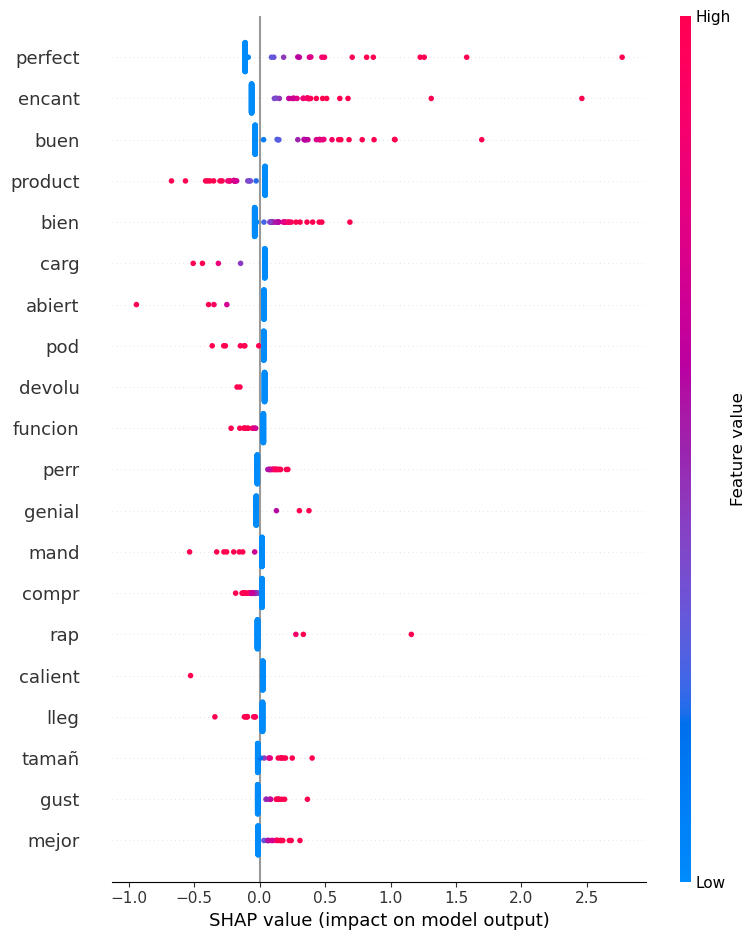

🔹 **Texto Original:** Como chubasquero excelente , y tambien aporta calor  , cuello muy suabe y de talla pues siempre una menos. Calidad north face
🔹 **Texto Procesado:** chubasquer excelent   tambi aport calor    cuell suab tall pues siempr men calid north fac
--------------------------------------------------------------------------------
🔹 **Texto Original:** El precio bien, el sabor regular
🔹 **Texto Procesado:** preci bien sabor regul
--------------------------------------------------------------------------------
🔹 **Texto Original:** Súper recomendable, es muy divertido y entretenido
🔹 **Texto Procesado:** sup recomend divert entreten
--------------------------------------------------------------------------------
🔹 **Texto Original:** Sabe pues a eso,a donetes mojados en leche ,no se nota apenas el sabor edulcorado (que eso lo odio) un 10!
🔹 **Texto Procesado:** sab pues eso donet moj lech not apen sabor edulcor odi
--------------------------------------------------------------

In [11]:
#SHAP values: Cuánto cada feature aumenta o disminuye la predicción comparado con el valor base.

import re
import spacy
import pandas as pd
import shap
import matplotlib.pyplot as plt
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# Descargar y cargar modelo de spaCy
tokenizer = spacy.load("es_core_news_sm")

# Cargar dataset
df = pd.read_csv("data/reviews.csv")

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

# Inicializamos el stemmer y las palabras vacías (stopwords)
stemmer = SnowballStemmer("spanish")
STOP_WORDS = set(stopwords.words('spanish'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    doc = tokenizer(text)
    tokens = [stemmer.stem(token.text) for token in doc if token.text not in STOP_WORDS and not token.is_punct]
    return ' '.join(tokens)


# Aplicar preprocesamiento
df['processed_review'] = df['review'].apply(preprocess_text)

# Vectorización con TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_review'])
y = df['stars']

# Convertir a clasificación binaria (Positivo = 4-5, Negativo = 1-2)
df['sentiment'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0 if x <= 2 else None)
df = df.dropna()
X = vectorizer.transform(df['processed_review'])
y = df['sentiment']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Entrenar modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

# Explicar con SHAP
explainer = shap.Explainer(model, X_train_res.toarray())  # Convertir a array denso
shap_values = explainer(X_test.toarray())  # También convertir el test set


# Visualizar importancia de palabras en una predicción
index = 0  # Índice de la reseña a analizar
shap.summary_plot(shap_values, X_test.toarray(), feature_names=vectorizer.get_feature_names_out())
plt.show()

# Mostrar algunos ejemplos antes y después del preprocesamiento
num_examples = 5  # Número de ejemplos a imprimir
sample_reviews = df[['review', 'processed_review']].sample(num_examples, random_state=41)

for i, row in sample_reviews.iterrows():
    print(f"🔹 **Texto Original:** {row['review']}")
    print(f"🔹 **Texto Procesado:** {row['processed_review']}")
    print("-" * 80)

